This notebook demonstrates regression and adaptive sampling using the Ackley function using the AckleyCompleteKernel.

The Ackley Kernel implements all of the Ackley kernel math in one class.

The first step is to import required libraries.

In [1]:
from gumps.apps.adaptive_sampler import AdaptiveSamplerApp, AdaptiveSamplerAppParameters
from gumps.solvers.adaptive_solver import AdaptiveSamplerParameters

from gumps.solvers.regressors.gaussian_regressor import GaussianRegressor
from gumps.solvers.regressors.regression_solver import RegressionParameters
from gumps.solvers.regressors.mlp_regressor import MultiLayerPerceptronRegressor, MultiLayerPerceptronRegressionParameters
from gumps.solvers.regressors.polynomial_regressor import PolynomialRegressor, PolynomialRegressionParameters
from gumps.solvers.regressors.bayesian_regressor import BayesianRegressor, BayesianRegressionParameters

from gumps.kernels.ackley_complete_kernel import AckleyCompleteKernel

from gumps.common.parallel import MultiprocessParallel
from gumps.studies.batch_study import BatchStudyMultiProcess
from gumps.studies.study import SimpleSimulationStudy

from gumps.solvers.sampler import SamplerSolverParameters
from gumps.apps.parametric_sweep import ParametricSweepApp

from gumps.graph.regressor import RegressorPlotParameters, RegressorPlot

import pandas as pd
import numpy as np

from pymoo.problems import get_problem
from pymoo.visualization.fitness_landscape import FitnessLandscape

%matplotlib inline

What does the Ackley function look like?

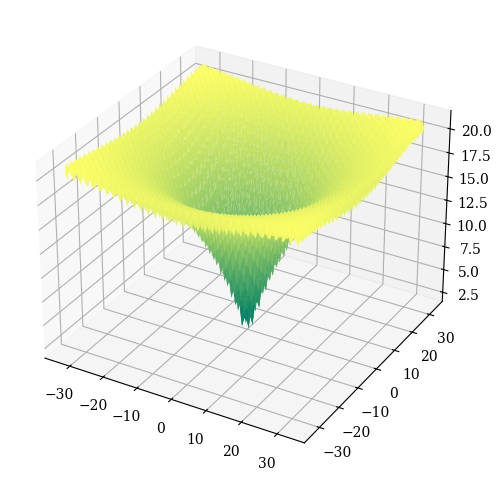

In [2]:
problem = get_problem("ackley", n_var=2, a=20, b=0.1, c=2 * np.pi)

FitnessLandscape(problem, n_samples=100, _type="surface").show()

The next step is to sample the function at a set of points. We will use a sobol sequence for this.

In [3]:
parameters = SamplerSolverParameters(
    number_of_samples = 128,
    lower_bound = {'x1':-32, 'x2':-32, 'a':19, 'b':0.05, 'c':np.pi},
    upper_bound = {'x1':32,  'x2':32, 'a':20, 'b':0.1, 'c':2*np.pi},
    sampler = "sobol"
    )
model_variables = {}

We also need to create a BatchStudy from the AckleyCompleteKernel

In [4]:
kernel = AckleyCompleteKernel()

problem = {'x' : np.array([1,2]),'a' : 1,'b' : 2 ,'c' : 1}

study = SimpleSimulationStudy(problem=problem, kernel=kernel)
parallel = MultiprocessParallel(poolsize=4)

batch = BatchStudyMultiProcess(study=study, parallel=parallel)

Here we create a function that can convert the output of the sampler to a format used by the regression models.

In [5]:
def pre_processing_function(input_data: pd.DataFrame):
    "pre-process the data"
    input_data_processed = {}
    input_data_processed['x'] = list(np.column_stack([input_data.x1, input_data.x2]))
    input_data_processed['a'] = input_data.a
    input_data_processed['b'] = input_data.b
    input_data_processed['c'] = input_data.c

    return pd.DataFrame(input_data_processed)

Here we create a function that can add noise to the data.

In [6]:
def get_all_with_noise(frame:pd.DataFrame) -> pd.DataFrame:
    "processing function to get the total from the dataframe"
    import numpy as np
    return {'total':frame['total'].values[0] * np.random.normal(1, 0.1)}

Then we need to run the sampling

In [7]:
app = ParametricSweepApp(parameters=parameters,
        processing_function=get_all_with_noise,
        pre_processing_function=pre_processing_function,
        directory=None,
        batch=batch)
app.run()

Next lets grab all the factors, responses.

In [8]:
factors = app.factors
responses = app.responses

Lets build a basic regression model using Gaussian Processes.

In [9]:
regression_parameters = RegressionParameters(input_data=factors,
            output_data=responses)
regressor = GaussianRegressor(regression_parameters)
regressor.fit()

We can then look at how well the model fits the data.

The first step is to look at the error metrics.

In [10]:
regressor.error_metrics()

score                                 -0.185759
r2_score                              -0.185759
mean_squared_error                    17.737686
mse                                   17.737686
root_mean_squared_error                4.211613
rmse                                   4.211613
normalized_mean_squared_error          0.038551
nmse                                   0.038551
normalized_root_mean_squared_error     0.196345
nrmse                                  0.196345
dtype: float64

The next step is to look at a response plot. In order to do that we need to choose a starting point and the bounds of the response plot.

For this we are going to use the mean value as the center of the response plot and the upper and lower bounds of the sampled region.

In [11]:
start = regression_parameters.input_data.mean()

lower_bound = regression_parameters.input_data.min()

upper_bound = regression_parameters.input_data.max()
params = RegressorPlotParameters(regressor, start, lower_bound, upper_bound)

Now lets look at the response plot.

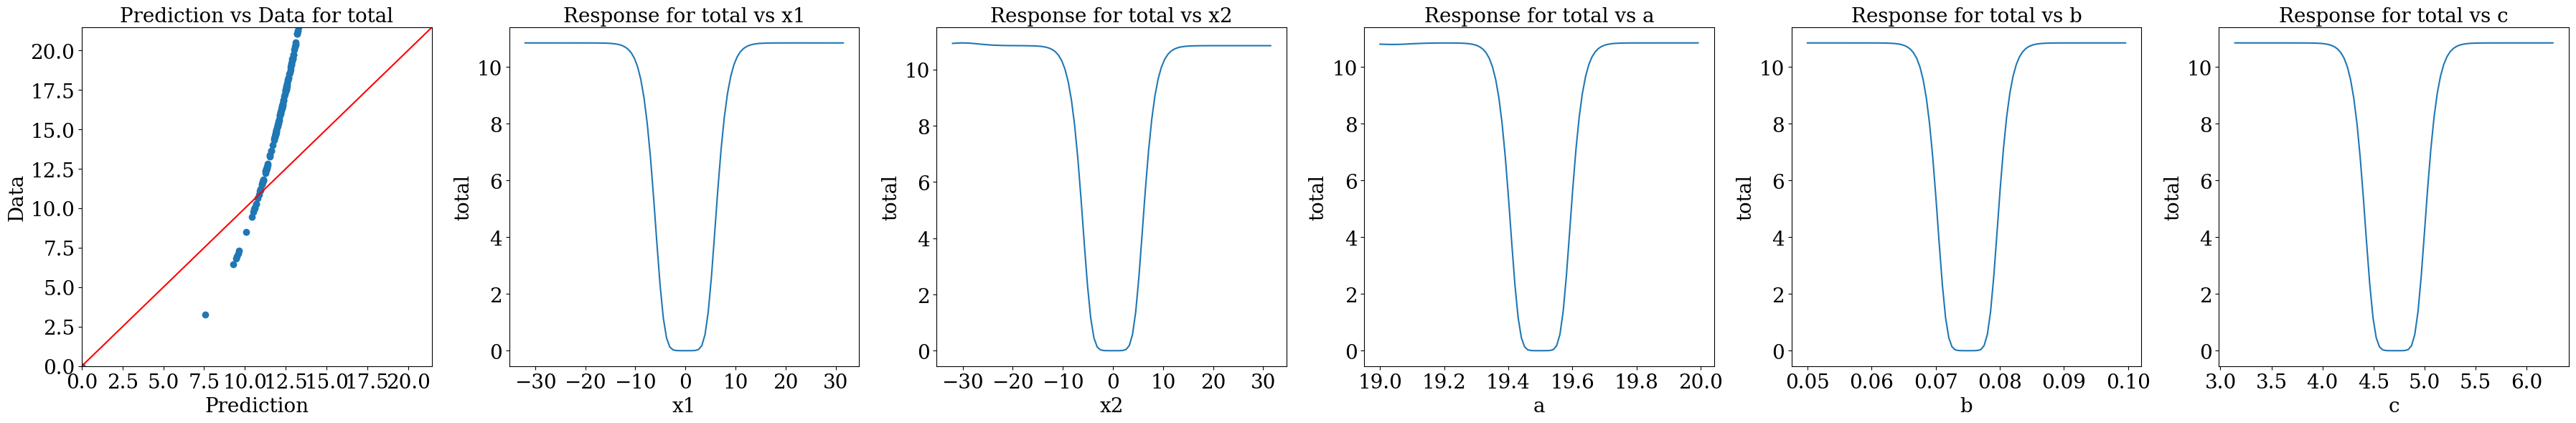

In [12]:
reg_plot = RegressorPlot(params)
reg_plot.plot()

Other models can be used in the same way.

Now lets look at the MultiLayer Perceptron Regression model

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/li

Error: -47821.238774966725


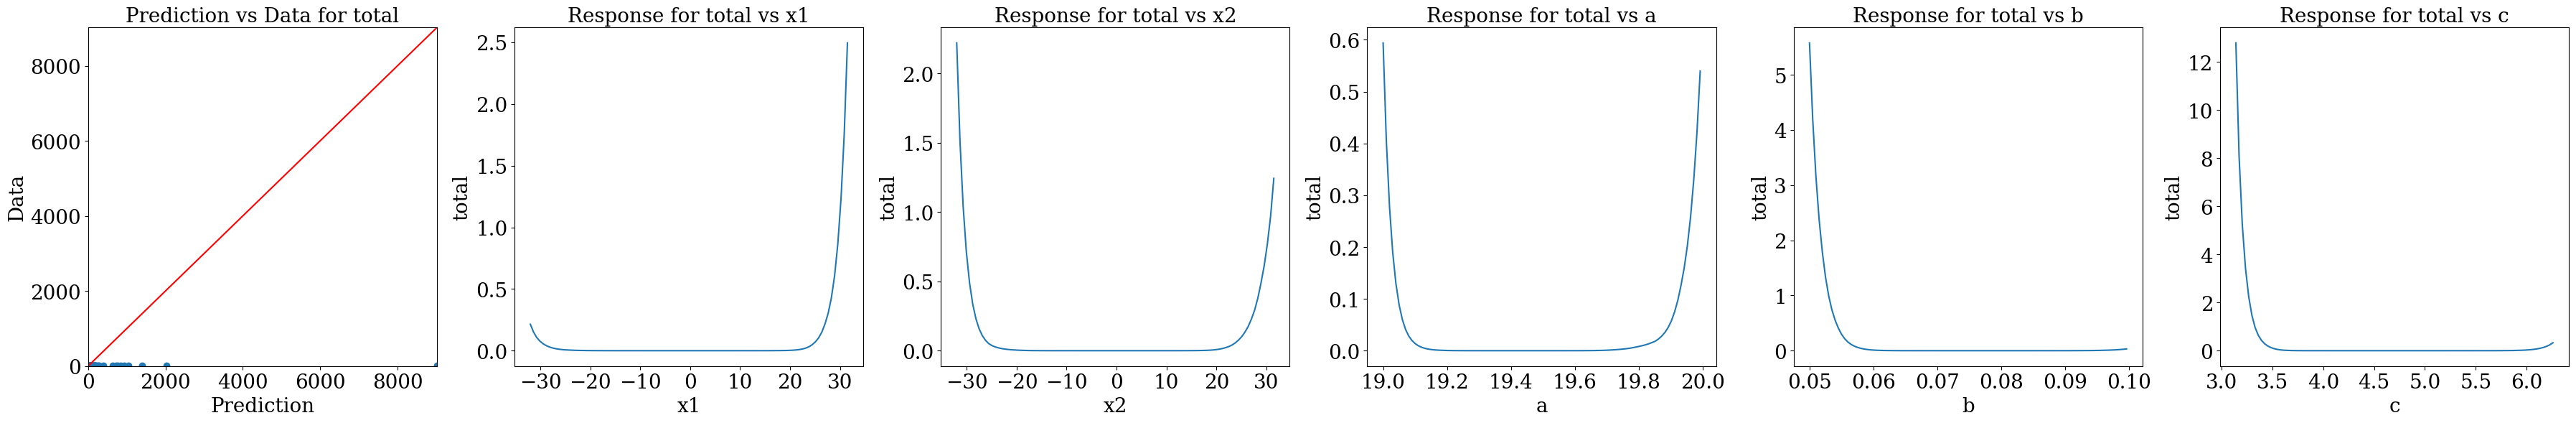

In [13]:
mlp_reg_data = MultiLayerPerceptronRegressionParameters(input_data=factors, output_data=responses)

mlp_regressor = MultiLayerPerceptronRegressor(mlp_reg_data)
mlp_regressor.fit()
print(f"Error: {mlp_regressor.error_metrics()['score']}")

params = RegressorPlotParameters(mlp_regressor, start, lower_bound, upper_bound)

reg_plot = RegressorPlot(params)
reg_plot.plot()

Now lets look at a 1st order polynomial regression model.

Error: -1.0835384846318665


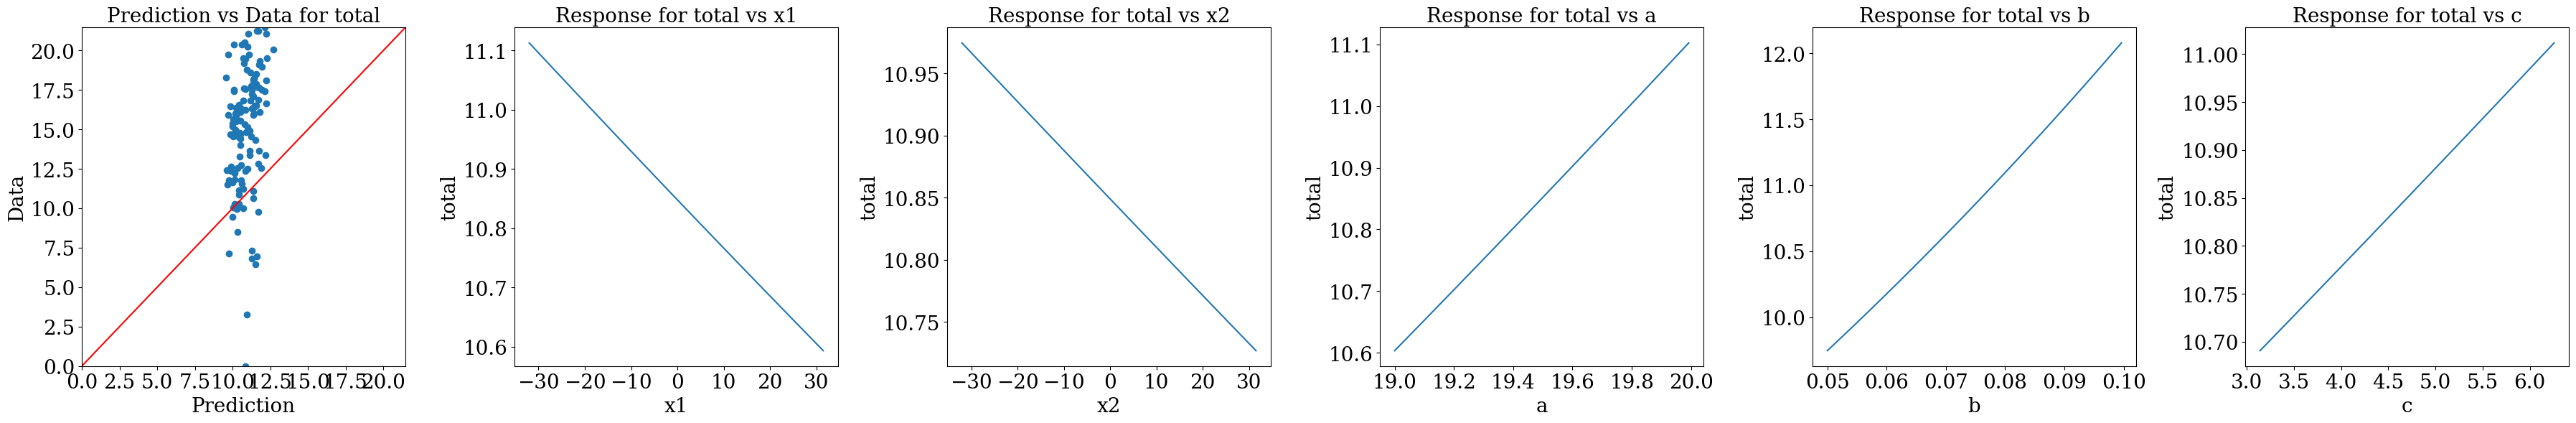

In [14]:
reg_data = PolynomialRegressionParameters(input_data=factors, output_data=responses, order=1)

regressor = PolynomialRegressor(reg_data)
regressor.fit()
print(f"Error: {regressor.error_metrics()['score']}")

params = RegressorPlotParameters(regressor, start, lower_bound, upper_bound)

reg_plot = RegressorPlot(params)

reg_plot.plot()

How does it look with a 2nd order model?

Error: -38.31772758422676


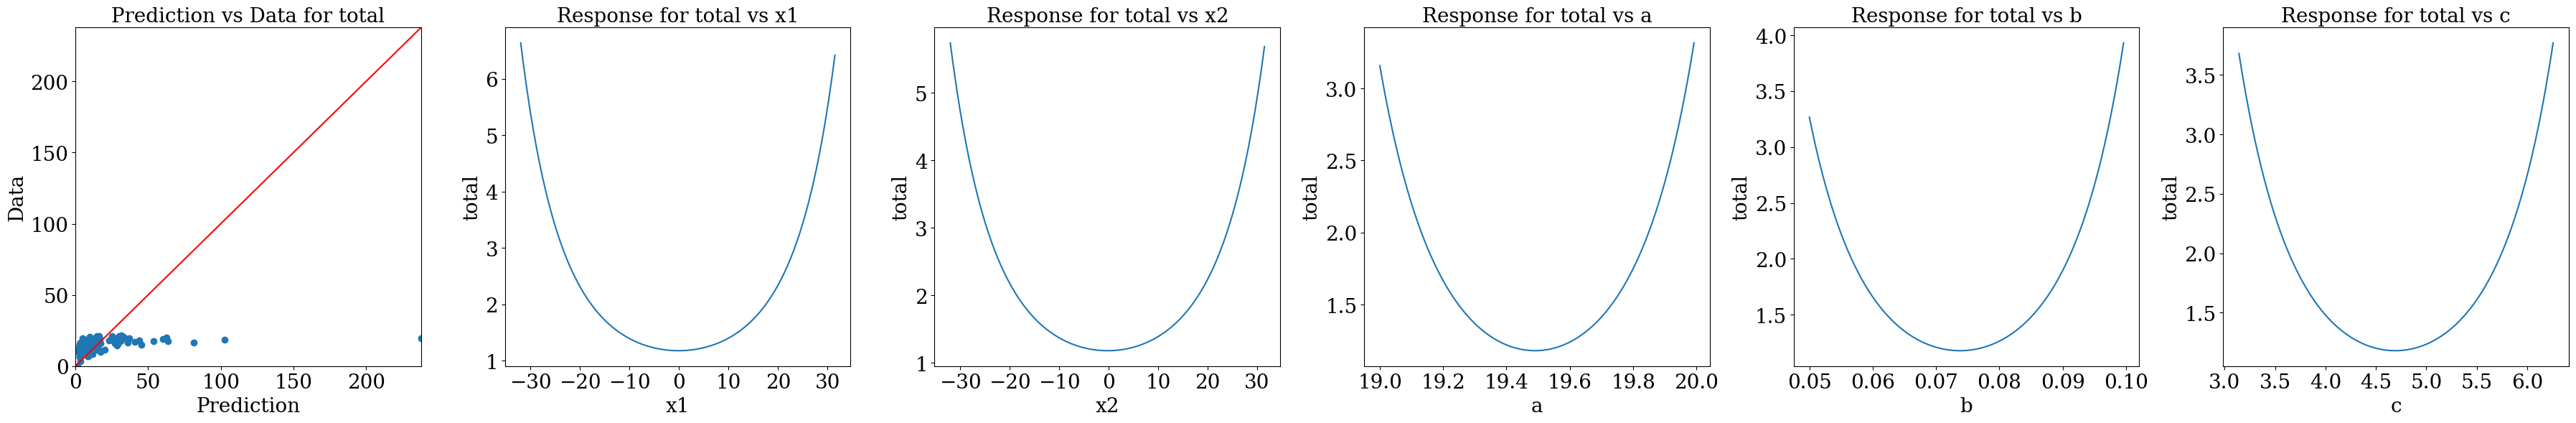

In [15]:
reg_data = PolynomialRegressionParameters(input_data=factors, output_data=responses, order=2)

regressor = PolynomialRegressor(reg_data)
regressor.fit()
print(f"Error: {regressor.error_metrics()['score']}")

params = RegressorPlotParameters(regressor, start, lower_bound, upper_bound)

reg_plot = RegressorPlot(params)

reg_plot.plot()

Next lets try adding points to the model using the adaptive sampling algorithm.

For this we need a Guassian Process model.


In [16]:
gpr_regression_parameters = RegressionParameters(input_data=factors,
            output_data=responses)
gpr_regressor = GaussianRegressor(gpr_regression_parameters)
gpr_regressor.fit()

Visualize the regressor.

Score -0.1858


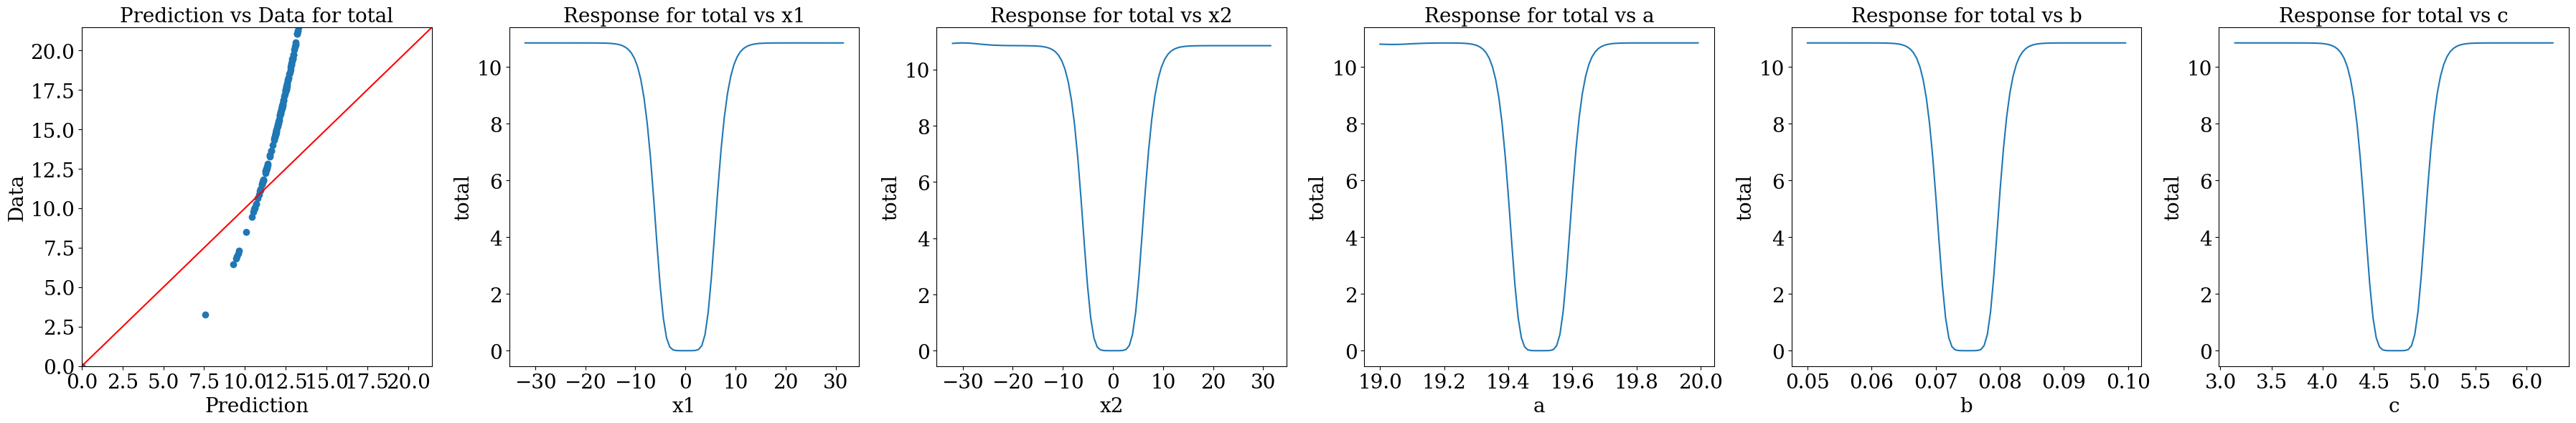

In [17]:
print(f"Score {gpr_regressor.error_metrics()['score']:.4f}")

params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)
reg_plot = RegressorPlot(params)
reg_plot.plot()

Lets use the adaptive sampler to additional points to the model.

In this case lets add 50 new points using 2 at a time. In order to find the next point we will sample the regressor with a population of 100 with 100 iterations.

In [18]:
sampler_parameters = AdaptiveSamplerParameters(
    points_to_add=50,
    batch_size=2,
    max_iterations=100,
    population_size=100
)

parameters = AdaptiveSamplerAppParameters(
    regressor=gpr_regressor,
    sampler_parameters = sampler_parameters
    )

app = AdaptiveSamplerApp(parameters=parameters,
                            batch=batch,
                            processing_function=get_all_with_noise,
                            pre_processing_function=pre_processing_function)
app.run()

Lets visualize the regressor again and see how this worked, we can clearly see that the point are spread out around the space.

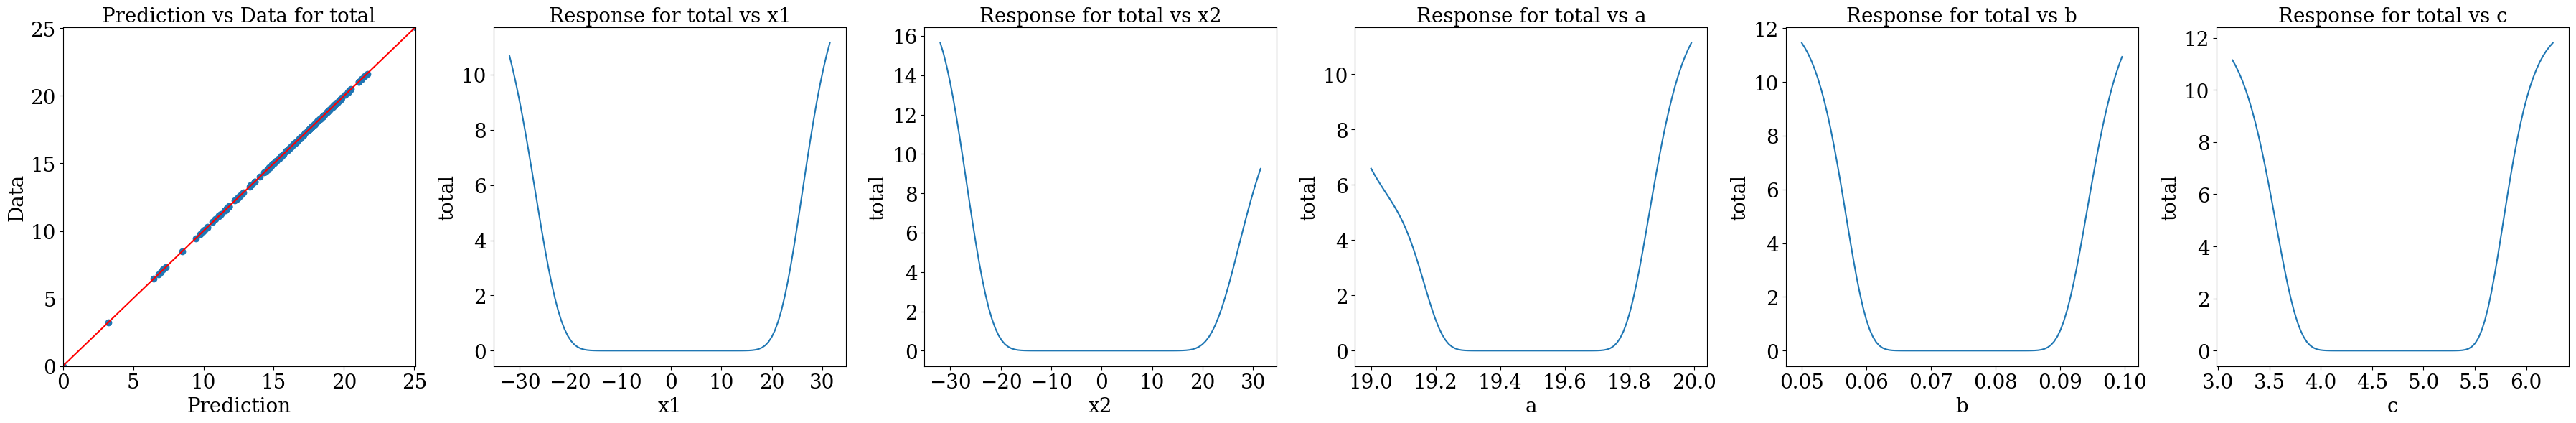

In [19]:
params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)

reg_plot = RegressorPlot(params)
reg_plot.plot()

Lets look at the error metrics.

In [20]:
print(f"Score {gpr_regressor.error_metrics()['score']:.4f}")

Score 1.0000


Lets sample even more points and see how the model improves. This time we will add 100 more points and select one point at a time.

In [21]:
sampler_parameters = AdaptiveSamplerParameters(
    points_to_add=100,
    batch_size=1,
    max_iterations=100,
    population_size=100
)

parameters = AdaptiveSamplerAppParameters(
    regressor=gpr_regressor,
    sampler_parameters = sampler_parameters
    )

app = AdaptiveSamplerApp(parameters=parameters,
                            batch=batch,
                            processing_function=get_all_with_noise,
                            pre_processing_function=pre_processing_function)
app.run()

Once again we can look at the response plot.

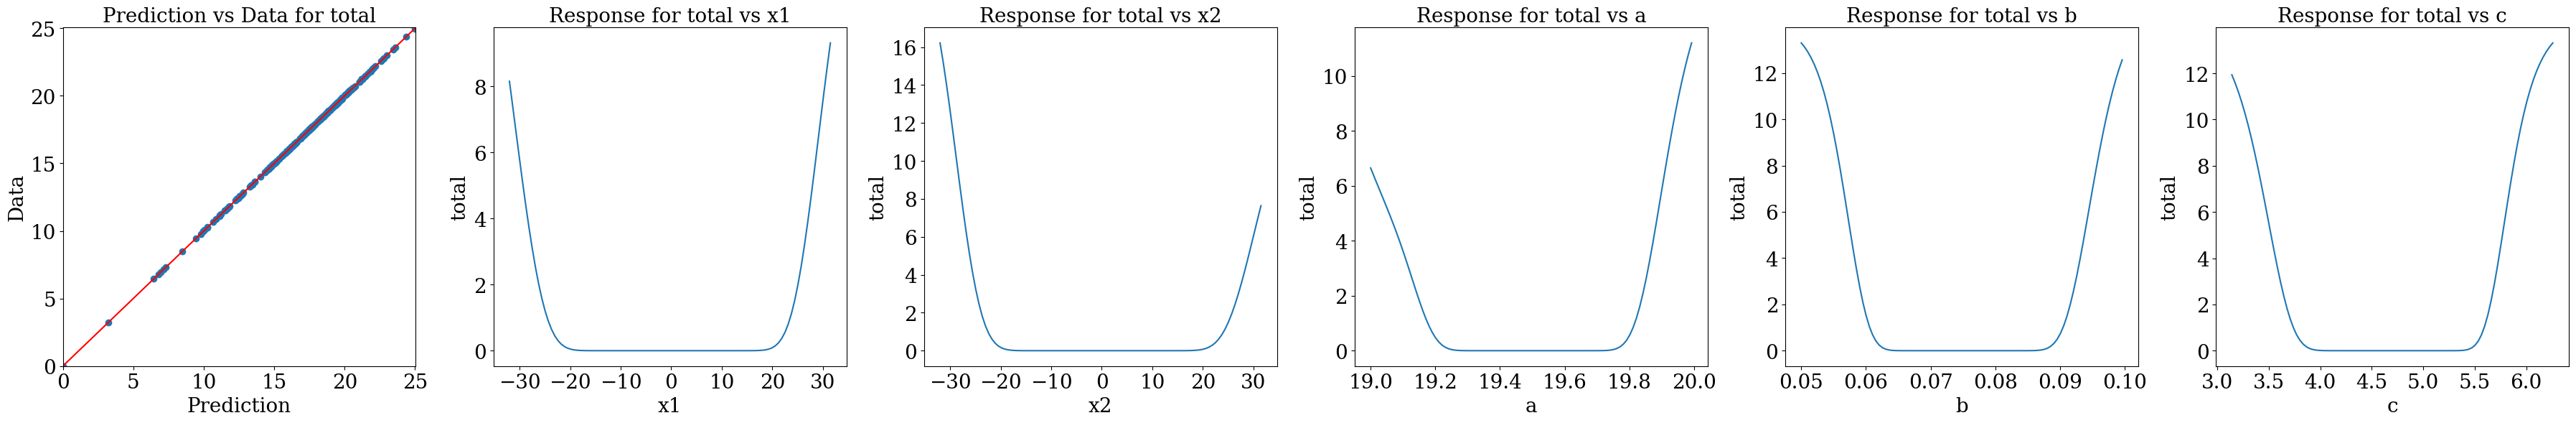

In [22]:
params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)

reg_plot = RegressorPlot(params)
reg_plot.plot()

And the error metrics.

In [23]:
gpr_regressor.error_metrics()

score                                 1.000000e+00
r2_score                              1.000000e+00
mean_squared_error                    6.166813e-09
mse                                   6.166813e-09
root_mean_squared_error               7.852906e-05
rmse                                  7.852906e-05
normalized_mean_squared_error         9.825433e-12
nmse                                  9.825433e-12
normalized_root_mean_squared_error    3.134555e-06
nrmse                                 3.134555e-06
dtype: float64

Now that the adaptive sampler has finished running we can train a simpler model using the points.

First lets try using a 1st order Bayesian polynomial regression model with all the data gathered.

Score -0.4321


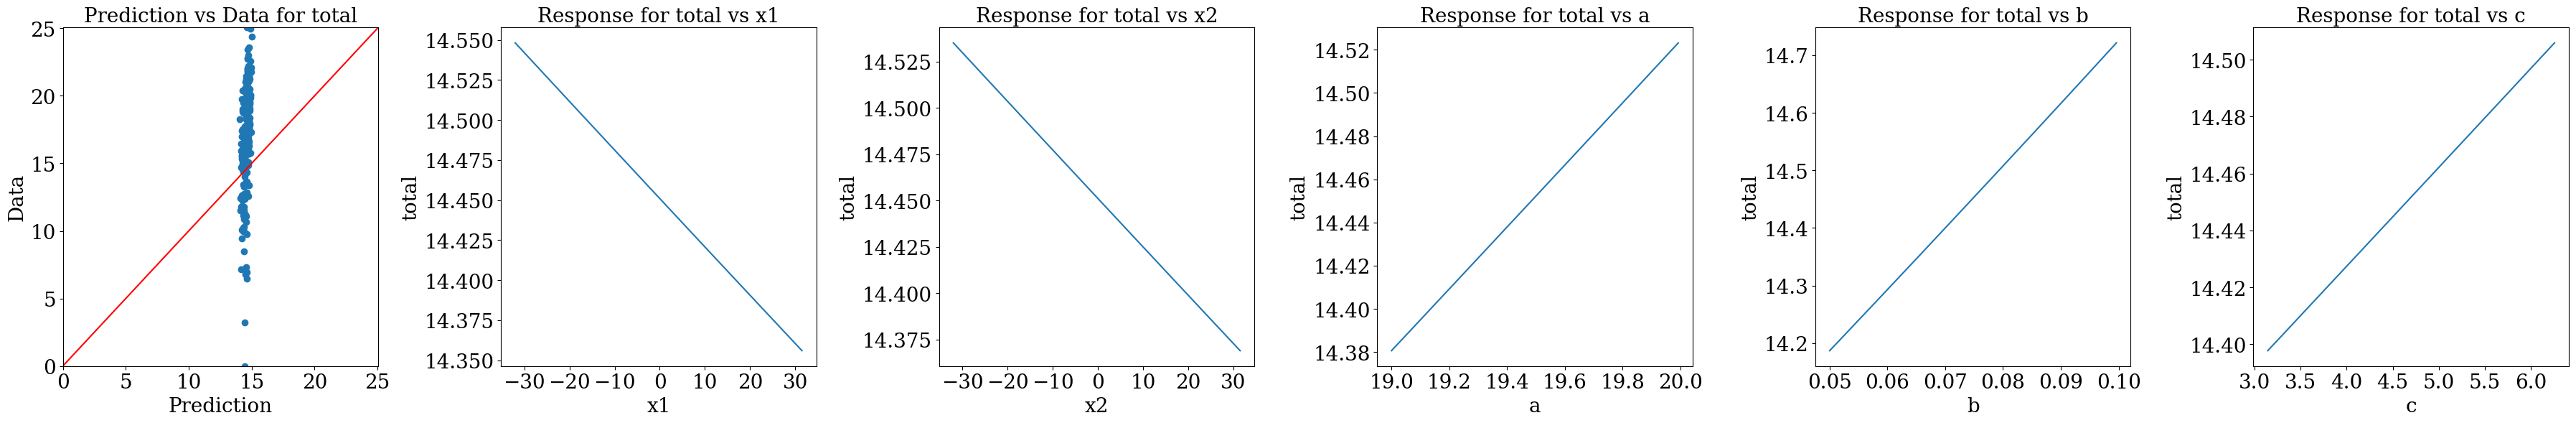

In [24]:
gpr_regression_parameters = BayesianRegressionParameters(
                                                input_data=gpr_regressor.parameters.input_data,
                                                output_data=gpr_regressor.parameters.output_data, 
                                                order=1)
gpr_regressor = BayesianRegressor(gpr_regression_parameters)
gpr_regressor.fit()

print(f"Score {gpr_regressor.error_metrics()['score']:.4f}")

params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)
params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)
reg_plot = RegressorPlot(params)
reg_plot.plot()

Clearly for this problem a 1st order model can't capture the data so lets try a 2nd order model.

Score -0.3938


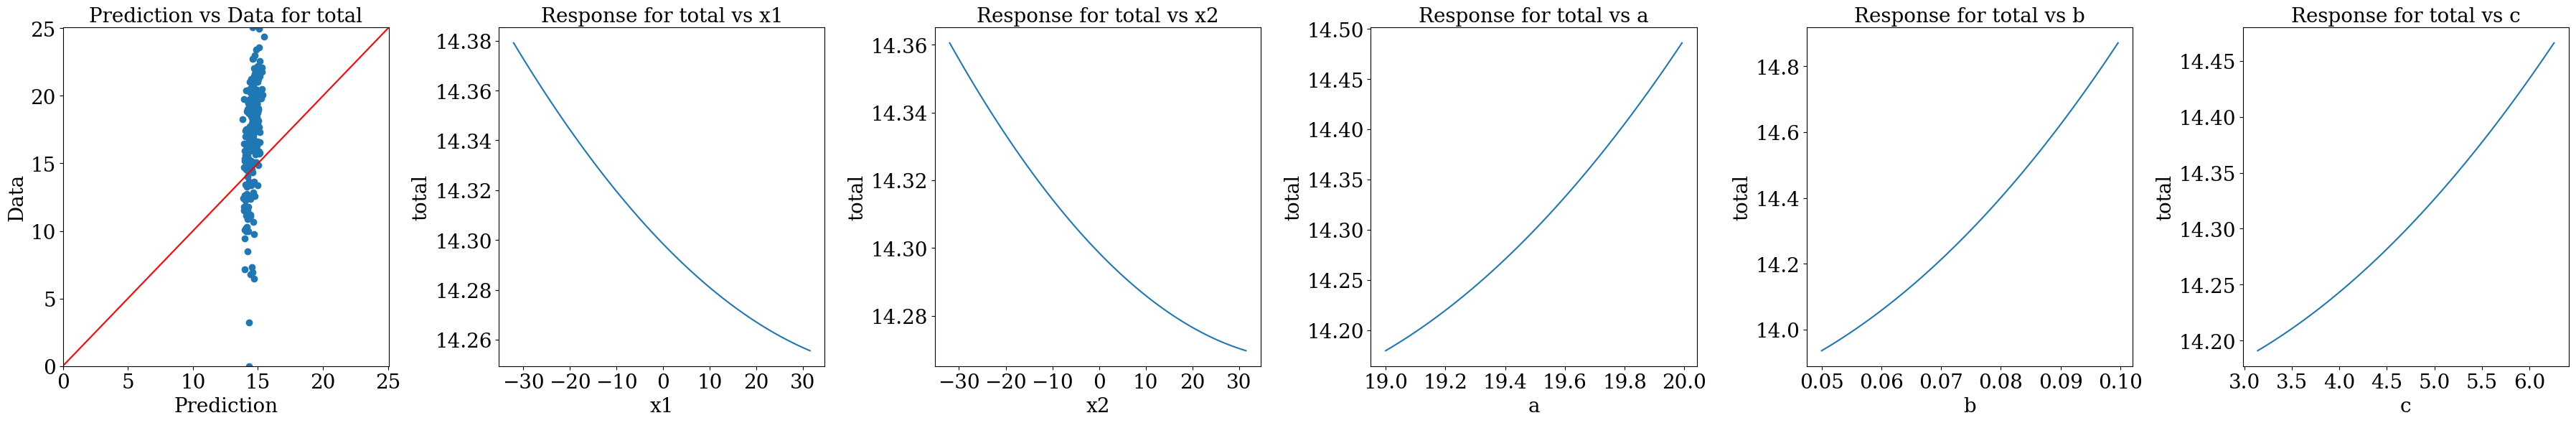

In [25]:
gpr_regression_parameters = BayesianRegressionParameters(
                                                input_data=gpr_regressor.parameters.input_data,
                                                output_data=gpr_regressor.parameters.output_data, 
                                                order=2)
gpr_regressor = BayesianRegressor(gpr_regression_parameters)
gpr_regressor.fit()

print(f"Score {gpr_regressor.error_metrics()['score']:.4f}")

params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)
params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)
reg_plot = RegressorPlot(params)
reg_plot.plot()

What about a 3rd order model?

Score -0.3595


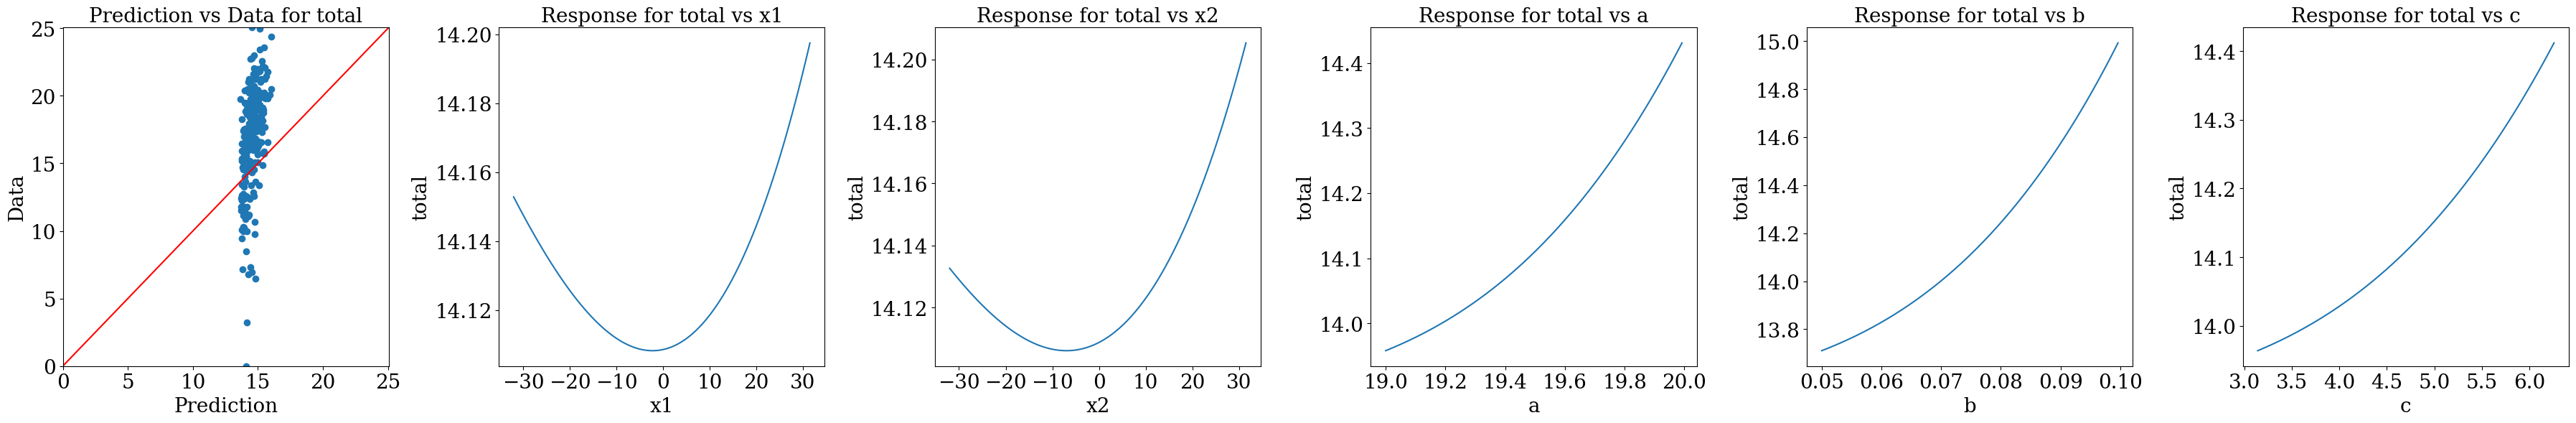

In [26]:
gpr_regression_parameters = BayesianRegressionParameters(
                                                input_data=gpr_regressor.parameters.input_data,
                                                output_data=gpr_regressor.parameters.output_data, 
                                                order=3)
gpr_regressor = BayesianRegressor(gpr_regression_parameters)
gpr_regressor.fit()

print(f"Score {gpr_regressor.error_metrics()['score']:.4f}")

params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)
params = RegressorPlotParameters(gpr_regressor, start, lower_bound, upper_bound)
reg_plot = RegressorPlot(params)
reg_plot.plot()